In [1]:
# default_exp models

# Import

In [2]:
#export
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from IPython.core.debugger import set_trace
from PIL import Image

from style_transfer.data import *

# Config

In [3]:
dir_data = Path('data')
dir_cont = dir_data/'content'
dir_styl = dir_data/'style'

# Utility

In [4]:
#export
def leaf_modules(model): # TODO: does pytorch have a built-in for this?
    for m in model.modules():
        if len(list(m.children())) == 0:
            yield m

In [5]:
#export
def gram_matrix(x):
    n,c,h,w = x.shape
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [6]:
#export
def get_in_channels(module):
    # Gets in_channels of first conv layer
    in_channels = None
    for m in leaf_modules(module):
        if isinstance(m, nn.modules.conv._ConvNd):
            in_channels = m.in_channels
            break
    return in_channels

In [7]:
#export
def get_out_channels(module):
    # Gets out_channels of last conv layer
    out_channels = None
    for m in leaf_modules(module):
        if isinstance(m, nn.modules.conv._ConvNd):
            out_channels = m.out_channels
    return out_channels

In [8]:
#export 
class reflection_conv(nn.Module):
    def __init__(self, ic, oc, ks, s, b=True):
        super().__init__()        
        self.pad = nn.ReflectionPad2d((ks-1)//2)
        self.conv = nn.Conv2d(ic, oc, ks, s, bias=b)
        
    def forward(self, X):
        X = self.pad(X)
        return self.conv(X)

In [9]:
#export
def conv_layer(ic, oc, ks, s):
    return nn.Sequential(
        reflection_conv(ic, oc, ks, s, b=False), # No bias needed since norm layer
        nn.GroupNorm(1, oc),
        nn.ReLU(inplace=True)
    )

In [10]:
#export
def up_conv_layer(ic, oc, ks, s, sf):
    return nn.Sequential(
        nn.Upsample(scale_factor=sf, mode='nearest'),
        conv_layer(ic, oc, ks, s)
    )

In [11]:
#export
def get_encoder(ic, layout_e):
    prev_oc = ic
    encoder = []
    for idx_l, layout_l in enumerate(layout_e):
        layer = []
        for idx_c, layout_c in enumerate(layout_l):
            s = 1 if (idx_c < len(layout_l)-1) or (idx_l == len(layout_e)-1) else 2
            layer.append(conv_layer(prev_oc, *layout_c, s))
            prev_oc = layout_c[0]
        encoder.append(nn.Sequential(*layer))
    return nn.Sequential(*encoder)

# Feature loss

In [12]:
#export
class FeatureLoss():
    def __init__(self, encoder, file_img_styl, sz, idx_styl, idx_cont, w_styl, w_cont):
        # Set up encoder
        encoder = encoder.cuda()
        encoder.eval()
        for p in encoder.parameters(): p.requires_grad = False
        self.encoder = encoder

        # Use hooks + dummy pass to get feature modules (modules right before size change)
        def _hook(module, x, y): 
            if x[0].shape[2:] != y.shape[2:]:
                module.size_changed = True                
        hooks = [m.register_forward_hook(_hook) for m in leaf_modules(encoder)]
        encoder(torch.zeros(1, 3, sz, sz, device='cuda'))        
        m_feats, m_prev = [], None
        for m in leaf_modules(encoder):
            if hasattr(m, 'size_changed'):
                m_feats.append(m_prev)
            m_prev = m
        for h in hooks: h.remove()
        self.m_feats = m_feats
            
        # Hook modules for style and content loss
        def _hook(module, x, y): module.x = x[0]
        self.hooks = [self.m_feats[idx].register_forward_hook(_hook) for idx in set(idx_styl+idx_cont)]
        self.idx_styl, self.idx_cont = idx_styl, idx_cont
                            
        # Precompute style image gram matrix; these are constant
        img_styl = Image.open(file_img_styl)
        img_styl = F.to_tensor(img_styl)
        img_styl = F.normalize(img_styl, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img_styl = img_styl[None].cuda()
        self.encoder(img_styl)
        self.gms_styl = [gram_matrix(feat) for feat in self._get_styl_feats()]
        
        # Store weights
        self.w_styl, self.w_cont = w_styl, w_cont
        
    def _get_styl_feats(self):
        return [self.m_feats[idx].x for idx in self.idx_styl]

    def _get_cont_feats(self):
        return [self.m_feats[idx].x for idx in self.idx_cont]

    def __call__(self, y_hat, y):        
        # content target
        self.encoder(y)
        feats_cc = self._get_cont_feats()
        
        # network output - this should learn to normalize to imagenet stats?
        self.encoder(y_hat)
        feats_hs = self._get_styl_feats()
        feats_hc = self._get_cont_feats()
                            
        # Get losses
        loss = nn.functional.mse_loss        
        ls_s = [self.w_styl[idx]*loss(self.gms_styl[idx].repeat(feat_hs.shape[0],1,1), gram_matrix(feat_hs)) 
                for idx, feat_hs in enumerate(feats_hs)]
        ls_c = [self.w_cont[idx]*loss(feat_cc, feat_hc) 
                for idx, (feat_cc, feat_hc) in enumerate(zip(feats_cc, feats_hc))]
        l_s, l_c = map(sum, [ls_s, ls_c])
        l = l_s + l_c
        
        # Metrics
        metrics = {}
        for name_metric in self.get_metric_names(): 
            metrics[name_metric] = eval(name_metric + '.item()')

        return l, metrics
    
    def get_metric_names(self):
        return ['l', 'l_s', 'l_c']
    
    def __del__(self): 
        for h in self.hooks: h.remove()

# Model

In [13]:
#export
class AutoEncoder(nn.Module):
    def __init__(self, encoder, k_l=3):
        super().__init__()
        self.encoder = encoder
        self.k_l = k_l   
        self.decoder = self._get_decoder(encoder)
        
    def _get_decoder(self, encoder):
        # Assumes each level of encoder shrinks by a factor of 2 except for last
        decoder = []
        for idx, m in enumerate(reversed(encoder)):
            ic, oc = get_out_channels(m), get_in_channels(m)
            if idx < len(encoder)-1:
                layer = [up_conv_layer(ic, ic, 3, 1, 2), conv_layer(ic, oc, 3, 1)]
            else:
                layer = [reflection_conv(ic, oc, self.k_l, 1)] # Last layer; dont do relu, norm, or upsampling
            decoder.append(nn.Sequential(*layer))
        return nn.Sequential(*decoder)

    def forward(self, X):
        return self.decoder(self.encoder(X))

# Test

In [14]:
sz = 256

In [15]:
encoder = models.vgg16(pretrained=True).features

In [16]:
loss = FeatureLoss(encoder, 
                   dir_styl/'hiroshige_winter.jpg', 
                   sz, 
                   [0,1,2,3], 
                   [1],
                   [1e10, 1e10, 1e10, 1e10],
                   [1e5])

In [17]:
in_channels = 3

# [out_channels, kernel_size]
layout_encoder = [[[ 32,7]],
                  [[ 64,3], [ 64,3]],
                  [[128,3], [128,3], [128,3], [128,3], [128,3], [128,3], [128,3], [128,3]]]

encoder = get_encoder(in_channels, layout_encoder)

In [18]:
model = AutoEncoder(encoder, k_l=7)
model = model.cuda()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): reflection_conv(
          (pad): ReflectionPad2d((3, 3, 3, 3))
          (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), bias=False)
        )
        (1): GroupNorm(1, 32, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): reflection_conv(
          (pad): ReflectionPad2d((1, 1, 1, 1))
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
        (1): GroupNorm(1, 64, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): reflection_conv(
          (pad): ReflectionPad2d((1, 1, 1, 1))
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        )
        (1): GroupNorm(1, 64, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): 

In [19]:
dir_imgs = Path(dir_cont/f'formatted_{sz}')
file_trn = dir_cont/'trn.csv'

In [20]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

In [21]:
ds_trn = ImgCSVDataset(dir_imgs, file_trn, tfms=tfms)

In [22]:
X,y = ds_trn[5]
X,y = X[None], y[None]
X,y = X.cuda(), y.cuda()

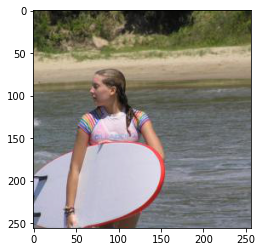

In [23]:
img = torch2np(X[0])
plt.imshow(denorm(img))

In [24]:
y_hat = model(X)

In [25]:
loss(y_hat, y)

(tensor(3917325.2500, device='cuda:0', grad_fn=<AddBackward0>),
 {'l': 3917325.25, 'l_s': 3526276.25, 'l_c': 391048.96875})

# Build

In [26]:
!nbdev_build_lib

Converted data.ipynb.
Converted format_images.ipynb.
Converted models.ipynb.
